<a href="https://colab.research.google.com/github/Ribli0308/GeneratingUniverse/blob/main/galaxies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import os
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Galaxies-Dataset"

In [ ]:
stats = (.5, .5, .5), (.5, .5, .5)

In [ ]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)

In [ ]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [ ]:
batch_size = 8

In [ ]:
train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

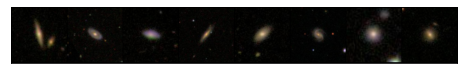

In [ ]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break
        
show_image(train_dl)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4
    
    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size=128

In [ ]:
generator = nn.Sequential(
    #in: 128 x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4
    
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()
    
    
)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    
    real_preds= discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    fake_preds= discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward(),
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))

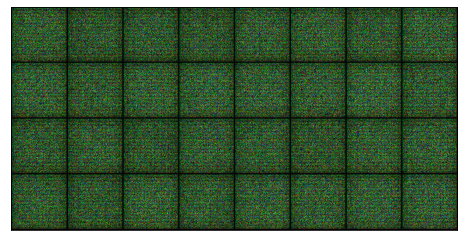

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)

In [ ]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_d, loss_g, real_score, fake_score))
        
        save_sample(epoch+start_idx, fixed_latent, show=False)
        
    return losses_d, losses_g, real_scores, fake_scores

In [ ]:
epochs = 20
lr_d = 10e-5
lr_g = 10e-4

In [ ]:
history = [fit(epochs, lr_d, lr_g, start_idx=1)]